# Logistic Regression With Mini-Batch Gradient Descent 
<h2>Objective</h2>
Represent your data as a Dataset object<br>
Create a Logistic Regression Model using PyTorch<br>
Set a Criterion to calculate Loss<br>
Create a Data Loader and set the Batch Size<br>
Create an Optimizer to update Model Parameters and set Learning Rate<br>
Train a Model

# Table of Contents
In this lab, you will learn how to train a PyTorch Logistic Regression model using Mini-Batch Gradient Descent.

Load Data<br>
Create the Model and Total Loss Function (Cost)<br>
Setting the Batch Size using a Data Loader<br>
Setting the Learning Rate<br>
Train the Model via Mini-Batch Gradient Descent<br>
Question

In [1]:
!pip3 install torch torchvision torchaudio

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/d0/5f/f41b14a398d484bf218d5167ec9061c1e76f500d9e25166117818c8bacda/torch-2.3.1-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/0f/02/8d3f83e01cf7fd72884fe84d4ff737ce774c5a7653bb826cf7acd39179f3/torchvision-0.18.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/41/c3/51482591d741c0c069f5825fe02d9ae387dc63eef2fe4cea1d1f3b07a623/torchaudio-2.3.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 23.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

The class plot_error_surfaces is just to help you visualize the data space and the parameter space during training and has nothing to do with Pytorch.

In [3]:
class plot_error_surfaces(object):
    
    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                yhat= 1 / (1 + np.exp(-1*(w2*self.x+b2)))
                Z[count1,count2]=-1*np.mean(self.y*np.log(yhat+1e-16) +(1-self.y)*np.log(1-yhat+1e-16))
                count2 += 1   
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x[self.y==0], self.y[self.y==0], 'ro', label="training points")
        plt.plot(self.x[self.y==1], self.y[self.y==1]-1, 'o', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')

In [4]:
# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

Set the random seed:

In [5]:
# Setting the seed will allow us to control randomness and give us reproducibility
torch.manual_seed(0)

# Load Data
The Dataset class represents a dataset. Your custom dataset should inherit Dataset which we imported above and override the following methods:

__len__ so that len(dataset) returns the size of the dataset.<br>

__getitem__ to support the indexing such that dataset[i] can be used to get ith sample<br>

Below we will create a sample dataset

In [6]:
# Create the custom Data class which inherits Dataset
class Data(Dataset):
    
    # Constructor
    def __init__(self):
        # Create X values from -1 to 1 with step .1
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        # Create Y values all set to 0
        self.y = torch.zeros(self.x.shape[0], 1)
        # Set the X values above 0.2 to 1
        self.y[self.x[:, 0] > 0.2] = 1
        # Set the .len attribute because we need to override the __len__ method
        self.len = self.x.shape[0]
    
    # Getter that returns the data at the given index
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    # Get length of the dataset
    def __len__(self):
        return self.len

In [7]:
#Make Data Object

data_set = Data()

#we can see the X values of dataset
data_set.x

#y values of the dataset Y
data_set.y

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [8]:
#length of the dataset
len(data_set)

20

In [11]:
x,y = data_set[0]
print("x = {}, y = {}".format(x,y))

x = tensor([-1.]), y = tensor([0.])


We can see the seperate two dimensional dataset into two classes

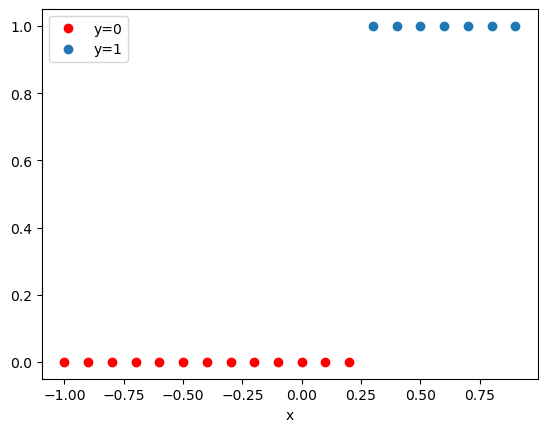

In [12]:
plt.plot(data_set.x[data_set.y == 0], data_set.y[data_set.y == 0], 'ro', label = "y=0")
plt.plot(data_set.x[data_set.y == 1], data_set.y[data_set.y == 1], 'o', label = "y=1")
plt.xlabel('x')
plt.legend()

# Create the Model and Total Loss Function (Cost)
For Logistic Regression typically we would not use PyTorch instead we would use Scikit-Learn as it is easier to use and set up. We are using PyTorch because it is good practice for deep learning. Scikit-Learn is typically used for Machine Learning while PyTorch is used for Deep Learning.<br>

We will create a custom class that defines the architecture of Logistic Regression using PyTorch. Logistic Regression has a single layer where the input is the number of features an X value of the dataset has (dimension of X) and there is a single output. The output of the layer is put into a sigmoid function which is a function between 0 and 1. The larger the output of the layer the closer it is to 1 and the smaller the output is the closer it is to 0. The sigmoid function will allow us to turn this output into a classification problem. If the output value is closer to 1 it is one class if it is closer to 0 it is in another.

Sigmoid Function

Image

In [13]:
# Create logistic_regression class that inherits nn.Module which is the base class for all neural networks

class logistic_regression(nn.Module):
    def __init__(self, n_inputs):
        
        super(logistic_regression, self).__init__()
        
        self.linear = nn.Linear(n_inputs,1)
        
        
    #prediction
    def forward(self,x):
        yhat = torch.sigmoid(self.linear(x))
        
        return yhat

We can check the number of features an X value has, the size of the input, or the dimension of X

In [14]:
x,y = data_set[0]
len(x)

1

Create a logistic regression object or model, the input parameter is the number of dimensions.

In [17]:
#create logistic regression result
model = logistic_regression(1)

In [18]:
#we can make a prediction using our data
x = torch.tensor([-1.0])

sigma = model(x)

sigma

tensor([0.5218], grad_fn=<SigmoidBackward0>)

In [19]:
#we can make a prediction using our data
x,y = data_set[2]

sigma = model(x)

sigma

tensor([0.4806], grad_fn=<SigmoidBackward0>)

Create a plot_error_surfaces object to visualize the data space and the learnable parameters space during training:

We can see on the Loss Surface graph, the loss value varying across w and b values with yellow being high loss and dark blue being low loss which is what we want

On the Loss Surface Contour graph we can see a top-down view of the Loss Surface graph